# Challenge Aim.
The notebook contain analysis of Cyclone/Storm event. This notebook describes the method for detecting the impact of cyclone in the region.
Models developed for this projects helps in understanding the following aspects.
> * Undamaged Commercial Building
> * Damaged Commercial Building.
> * Undamaged Residential Building.
> * Damaged Residential Building.

The dataset used for building these models is Maxar-GeoEye 1 (optical) which is single image of the area impacted by cyclone. The images are obtained for two different stages.
> * Pre Cyclone/Storm.
> * Post Cyclone/Storm.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install opencv-python-headless -q
%pip install ultralytics -q
!pip install labelme2yolo -q
!pip install gdal
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.5/719.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 24.2 MB/s eta 0:00:00


In [ ]:
# importing necessary libraries.
import os
import rasterio
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import tifffile as tiff
import labelme2yolo
import cv2
from osgeo import gdal

# Searching for require datasets

In [ ]:
#from PIL import tifffile
image_stack = tiff.imread("Pre_Event_San_Juan.tif")

In [ ]:
image_stack.shape

(74602, 38259, 3)

In [ ]:
image_stack.dtype

dtype('uint8')

In [ ]:
with tiff.TiffFile('Pre_Event_San_Juan.tif') as tif:
    tif_tags = {}
    for tag in tif.pages[0].tags.values():
        name,value = tag.name,tag.value
        tif_tags[name] = value
    image = tif.pages[0].asarray()

In [ ]:
print(tag.name)
print(tag.value)
print(tag.code)

GDAL_METADATA
<GDALMetadata>
  <Item name="COLORINTERP" sample="0" role="colorinterp">Red</Item>
  <Item name="COLORINTERP" sample="1" role="colorinterp">Green</Item>
  <Item name="COLORINTERP" sample="2" role="colorinterp">Blue</Item>
</GDALMetadata>
42112


In [ ]:
with tiff.TiffFile('Pre_Event_San_Juan.tif') as tif:
    num_pages = len(tif.pages)

In [ ]:
num_pages

1

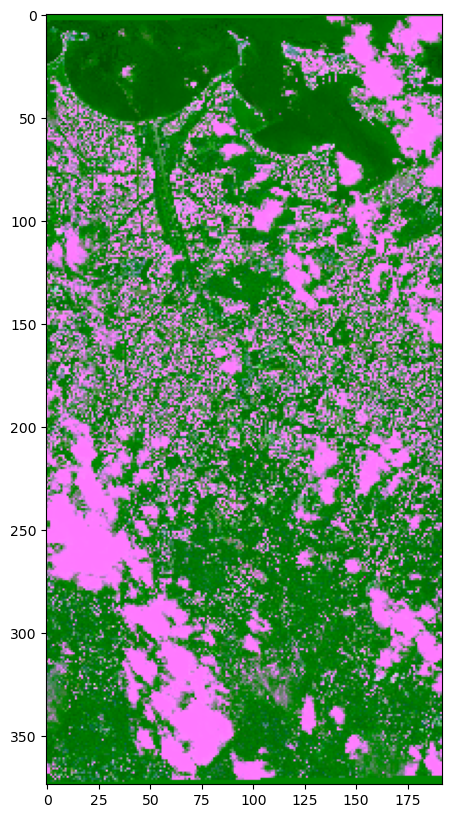

In [ ]:
downsampled_image = image_stack[::200,::200,:]
fig,ax = plt.subplots(figsize=(10,10))
plt.imshow(downsampled_image)
plt.show()

In [ ]:
image_post = tiff.imread('Post_Event_San_Juan.tif')
image_post.shape

(74602, 38259, 3)

In [ ]:
with tiff.TiffFile('Post_Event_San_Juan.tif') as tif:
    num_pages = len(tif.pages)
    print(num_pages)

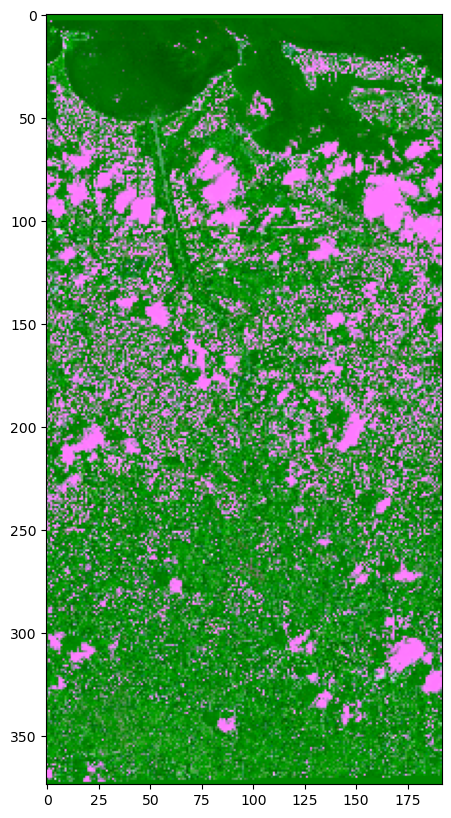

In [ ]:
downsample_image_post = image_post[::200,::200,:]
fig,ax = plt.subplots(figsize=(10,10))
plt.imshow(downsample_image_post)
plt.show()

## Loading using Rasterio.
After running the images using tifffile and matplotlib we can clearly see that the images are laoding properly.
The images are displayed in form of panchromatic images. In order for further analysis we need clear optical images. Hence we are using Rasterio.

In [ ]:
import rasterio

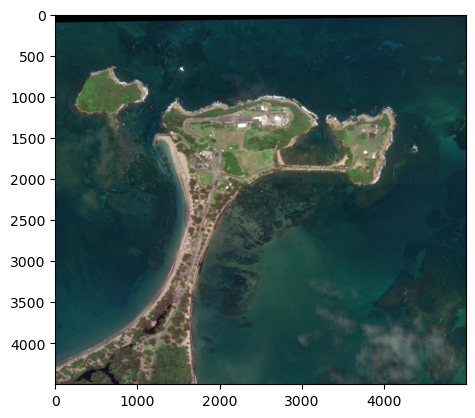

In [ ]:
with rasterio.open('Pre_Event_San_Juan.tif') as src:
    image_pre = src.read([1,2,3], window = ((500,5000),(0,5000)))

image_pre = image_pre/image_pre.max()
plt.imshow(image_pre.transpose(1,2,0))
plt.show()

In [ ]:
image_pre

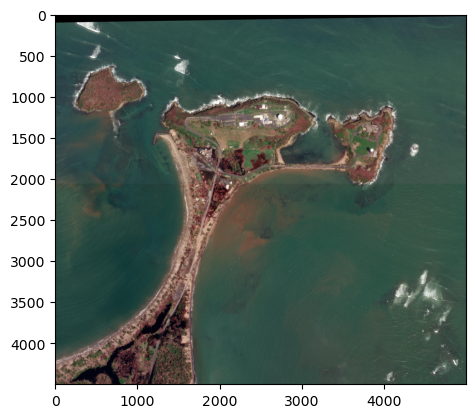

In [ ]:
with rasterio.open('Post_Event_San_Juan.tif') as src:
    image_post = src.read([1,2,3], window = ((500,5000),(0,5000)))

image_post = image_post/image_post.max()
plt.imshow(image_post.transpose(1,2,0))
plt.show()

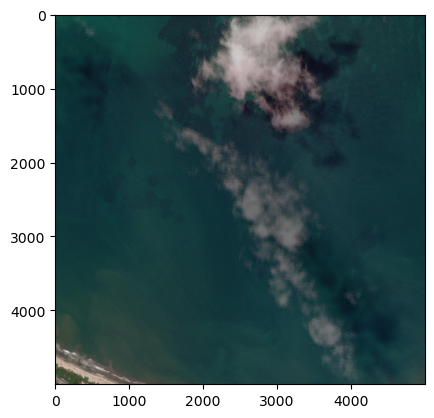

In [ ]:
image_lst = ['Pre_Event_San_Juan.tif','Post_Event_San_Juan.tif']
for event in image_lst:
    with rasterio.open(event) as src:
        image_ = src.read([1,2,3], window = ((5000,10000),(5000,10000)))
    image = image_ / image_.max()
    plt.imshow(image.transpose(1,2,0))
    plt.show()

# Data Preprocessing
* The size of images is large. Hence we want to create tiles for preprocessing the images which will also help in labelling.
* Also the assumption is there might undamaged buildings even after storm/hurricane/cyclone.

In [ ]:
import os
def generate_tiles(input_file,grid_x,grid_y,output_dir):
    ds = gdal.Open(input_file)

    #Image size and number of bands.
    width = ds.RasterXSize
    height = ds.RasterYSize
    bands = ds.RasterCount

    # Create number of tiles in each dimension
    num_tiles_x = (width // grid_x)
    num_tiles_y = (height // grid_y)

    print(f'Total number of tiles :{num_tiles_x * num_tiles_y}')

    # Creating output directory.
    os.makedirs(output_dir, exist_ok = True)

    # Iterating over each tile and saving it as seperate tiff image.
    for i in range(num_tiles_x):
        for j in range(num_tiles_y):
            x_off = i * grid_x
            y_off = j * grid_y

            tile_width = min(grid_x, width - x_off)
            tile_height = min(grid_y, width - y_off)

            tile = []
            for band in range(1, bands + 1):
                tile_data = ds.GetRasterBand(band).ReadAsArray(x_off,y_off,tile_width,tile_height)
                tile.append(tile_data)

            # Create output filename
            output_file = os.path.join(output_dir, f"tile_{i}_{j}.tif")

            # Create an output TIFF file with same CRS and band values.
            driver = gdal.GetDriverByName('GTiff')
            options = ["COMPRESS=DEFLATE","PREDICTOR=2","TILED=YES"]
            out_ds = driver.Create(output_file, tile_width, tile_height, bands,
                                   ds.GetRasterBand(1).DataType, options=options)

            # Geotransform.
            geotransform = list(ds.GetGeoTransform())
            geotransform[0] = geotransform[0] + x_off * geotransform[1]
            geotransform[3] = geotransform[3] + y_off * geotransform[5]
            out_ds.SetGeoTransform(tuple(geotransform))

            # Projection
            out_ds.SetProjection(ds.GetProjection())

            # Write each band to the output file.
            for band in range(1,bands + 1):
                out_band = out_ds.GetRasterBand(band)
                out_band.WriteArray(tile[band - 1])


            # Close the file
            out_ds = None

    print("Tiles are generated")

In [ ]:
input_file = 'Pre_Event_San_Juan.tif'
output_dir = "PlanetaryComputerExamples/Pre_Event_Grids_In_TIFF"
grid_x,grid_y = 512,512
generate_tiles(input_file,grid_x,grid_y,output_dir)

Total number of tiles :5476
Tiles are generated


In [ ]:
os.getcwd()

'/home/jovyan/PlanetaryComputerExamples'

In [ ]:
input_file = 'Post_Event_San_Juan.tif'
output_dir = "PlanetaryComputerExamples/Post_event_grid_in_tiff"
grid_x,grid_y = 512,512
generate_tiles(input_file,grid_x,grid_y,output_dir)

Total number of tiles :5476
Tiles are generated


 # Identification of Damaged and Undamaged Infrastructure.
 Commercial buildings often have larger rooftops and have big parking areas. However incase of residential building there are not larger rooftops. Not all damaged buildings have real impact and all undamaged buildings have negligible damage.
 We will create a labels for such buildings in image using labelme. Before labelling the image we need to convert image into jpeg/png as labelme accepts only jpeg/png format.

In [ ]:
import os
def convert_tiff_jpeg(input_dir,output_dir):
    #checking if output dir exists.
    os.makedirs(output_dir, exist_ok = True)

    # Opening the input dir and files in it.
    tiff_files = [file for file in os.listdir(input_dir) if file.endswith('.tif')]

    for filename in tiff_files:
        input_path = os.path.join(input_dir,filename)
        output_path = os.path.join(output_dir, os.path.splitext(filename)[0] + ".jpg")
        # Use gdal translate to convert to jpeg.
        os.system(f"gdal_translate -of JPEG -co PHOTOMETRIC=RGB -co TILED=YES -co COMPRESS=DEFLATE {input_path} {output_path}")

        #output_filename = os.path.splitext(filename)[0] + ".jpg"

        # Save the file
        #img.save(os.path.join(output_dir,output_filename),'JPEG')

    print('Conversion completed')

In [ ]:
input_dir = 'PlanetaryComputerExamples/Pre_Event_Grids_In_TIFF'
output_dir = 'PlanetaryComputerExamples/Pre_Event_Grids_JPEG'
convert_tiff_jpeg(input_dir,output_dir)

FileNotFoundError: [Errno 2] No such file or directory: 'PlanetaryComputerExamples/Pre_Event_Grids_In_TIFF'

In [ ]:
input_dir = 'PlanetaryComputerExamples/Post_event_grid_in_tiff'
output_dir = 'PlanetaryComputerExamples/Post_event_grids_jpeg'
convert_tiff_jpeg(input_dir,output_dir)

In [ ]:
input_dir = 'PlanetaryComputerExamples/Pre_Event_Grids_JPEG'
try:
    for file in os.listdir(input_dir):
        if file.endswith('.jpg.aux.xml'):
            file_path = os.path.join(input_dir,file)
            os.remove(file_path)
            print(f"Removed {file_path}")
except FileNotFoundError as e:
    print(f"The file {file} is not available")

In [ ]:
# Renaming files for better accessibility for future Reference.

def rename_files(input_dir):
    # Listing all files.
    files = os.listdir(input_dir)

    # creating prefix names.
    prefix = 'Pre_event'

    # creating number for prefix.
    number = 0

    # Looping through files.
    for filename in files:
        if os.path.isfile(os.path.join(input_dir,filename)):
            # File extension
            file_extension = os.path.splitext(filename)[1]

            #Create new file name
            new_file = f"{prefix}_{number}{file_extension}"

            # Comstruct new path for new files.
            old_filepath = os.path.join(input_dir, filename)
            new_filepath = os.path.join(input_dir, new_file)

            # Rename the path
            os.rename(old_filepath,new_filepath)

            #Increment the counter
            number += 1
    print('Files are renamed')

In [ ]:
rename_files('PlanetaryComputerExamples/Pre_Event_Grids_JPEG')

In [ ]:
rename_files('PlanetaryComputerExamples/Post_event_grids_jpeg')

In [ ]:
# Download YOLOv3 weights and configuration files
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true -O yolov3.cfg

--2024-02-27 09:41:43--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  35.9MB/s    in 11s     

2024-02-27 09:43:05 (21.5 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2024-02-27 09:43:05--  https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/pjreddie/darknet/raw/master/cfg/yolov3.cfg [following]
--2024-02-27 09:43:06--  https://github.com/pjreddie/darknet/raw/master/cfg/yolov3.cfg
Reusing existing connection to github.com:443.
HTTP request sent, awaiti

In [ ]:
import os
import cv2
# Set the directory path where the raster files are located
input_dir = '/content/drive/MyDrive/Coastal_Resilence/Data'

# Loop through each raster file in the input directory
for filename in os.listdir(input_dir):
    if filename.endswith('.jpg'):
        filepath = os.path.join(input_dir, filename)

        # Zoom factor
        zoom_factor = 8
        img = cv2.imread(filepath)

        # Calculate new height and new width.
        new_height = int(img.shape[0]*zoom_factor)
        new_width = int(img.shape[1]*zoom_factor)

        # Using INTER_CUBIC for better smooth zooming.
        interpolation = cv2.INTER_CUBIC

        # Resize the images.
        resized_img = cv2.resize(img,(new_width,new_height),interpolation = interpolation)

        # Output filename
        output_filename = f"{filename}_zoomed_{zoom_factor}x.jpg"

        # Saving the images.
        output_path = '/content/drive/MyDrive/Coastal_Resilence/Data'

        output_file_path = os.path.join(output_path,output_filename)
        cv2.imwrite(output_file_path,resized_img)
        print(f"Successfully zoomed images: {filename} -> {output_file_path}")


Successfully zoomed images: Post_event_1031.jpg -> /content/drive/MyDrive/Coastal_Resilence/Data/Post_event_1031.jpg_zoomed_8x.jpg
Successfully zoomed images: Post_event_102.jpg -> /content/drive/MyDrive/Coastal_Resilence/Data/Post_event_102.jpg_zoomed_8x.jpg
Successfully zoomed images: Post_event_101.jpg -> /content/drive/MyDrive/Coastal_Resilence/Data/Post_event_101.jpg_zoomed_8x.jpg
Successfully zoomed images: Post_event_1017.jpg -> /content/drive/MyDrive/Coastal_Resilence/Data/Post_event_1017.jpg_zoomed_8x.jpg
Successfully zoomed images: Post_event_103.jpg -> /content/drive/MyDrive/Coastal_Resilence/Data/Post_event_103.jpg_zoomed_8x.jpg
Successfully zoomed images: Post_event_1002.jpg -> /content/drive/MyDrive/Coastal_Resilence/Data/Post_event_1002.jpg_zoomed_8x.jpg
Successfully zoomed images: Post_event_10.jpg -> /content/drive/MyDrive/Coastal_Resilence/Data/Post_event_10.jpg_zoomed_8x.jpg
Successfully zoomed images: Post_event_100.jpg -> /content/drive/MyDrive/Coastal_Resilence/Da

In [ ]:
input_dir = '/content/drive/MyDrive/Coastal_Resilence/Data'
try:
    for file in os.listdir(input_dir):
        if file.endswith('.jpg_zoomed_4x.jpg'):
            file_path = os.path.join(input_dir,file)
            os.remove(file_path)
            print(f"Removed {file_path}")
except FileNotFoundError as e:
    print(f"The file {file} is not available")

In [ ]:
# Converting labelme 2 yolo format.
!pip install labelme2yolo

In [ ]:
# Separating data into red,green and blue layers.

def rgb_layers(input_path,output_path):
    """Gives output as images from the input folder. The output consist of rgb images of the original images."""
    # Extracting only jpg files
    data_files = [file for file in os.listdir(input_path) if file.endswith('.jpg')]

    # Opening files using rasterio
    for i,image in enumerate(data_files):
        img_path = os.path.join(input_path,image)
        img = cv2.imread(img_path,cv2.IMREAD_COLOR)
        blue_img = img[:,:,0]
        green_img = img[:,:,1]
        red_img = img[:,:,2]

        # reshaping data for saving.
        blue_output_path = os.path.join(output_path, f'blue_{image}.jpg')
        green_output_path = os.path.join(output_path, f'green_{image}.jpg')
        red_output_path = os.path.join(output_path, f'red_{image}.jpg')

        # Save individual channel images
        cv2.imwrite(blue_output_path, blue_img)
        cv2.imwrite(green_output_path, green_img)
        cv2.imwrite(red_output_path, red_img)
        print(f'RGB images created for {i} image out of',len(data_files))
    print(f"Individual Red, Green, and Blue images saved in {output_path}")

input_path = "/content/drive/MyDrive/Coastal_Resilence/Data"
output_path = "/content/drive/MyDrive/Coastal_Resilence/Data"

rgb_layers(input_path,output_path)

RGB images created for 0 image out of 848
RGB images created for 1 image out of 848
RGB images created for 2 image out of 848
RGB images created for 3 image out of 848
RGB images created for 4 image out of 848
RGB images created for 5 image out of 848
RGB images created for 6 image out of 848
RGB images created for 7 image out of 848
RGB images created for 8 image out of 848
RGB images created for 9 image out of 848
RGB images created for 10 image out of 848
RGB images created for 11 image out of 848
RGB images created for 12 image out of 848
RGB images created for 13 image out of 848
RGB images created for 14 image out of 848
RGB images created for 15 image out of 848
RGB images created for 16 image out of 848
RGB images created for 17 image out of 848
RGB images created for 18 image out of 848
RGB images created for 19 image out of 848
RGB images created for 20 image out of 848
RGB images created for 21 image out of 848
RGB images created for 22 image out of 848
RGB images created fo

In [ ]:
# Implementing data augmentation techniques using keras ImageDataGenerator.
from keras.preprocessing.image import ImageDataGenerator
import os
import cv2

datagen = ImageDataGenerator(
    rotation_range = 60,
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.4,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

input_path = "/content/drive/MyDrive/Coastal_Resilence/Data"
output_path = "/content/drive/MyDrive/Coastal_Resilence/Data"
img_files = [img for img in os.listdir(input_path) if img.endswith('jpg')]

for i,image in enumerate(img_files):
    img_path = os.path.join(input_path,image)
    loaded_img = cv2.imread(img_path)
    aug_img = next(datagen.flow(np.expand_dims(loaded_img, 0)))[0]
    cv2.imwrite(os.path.join(output_path, f'aug_{image}_{i}.jpg'), aug_img)
    print(f"Augmented Image {i} out of",len(img_files))


Augmented Image 0 out of 424
Augmented Image 1 out of 424
Augmented Image 2 out of 424
Augmented Image 3 out of 424
Augmented Image 4 out of 424
Augmented Image 5 out of 424
Augmented Image 6 out of 424
Augmented Image 7 out of 424
Augmented Image 8 out of 424
Augmented Image 9 out of 424
Augmented Image 10 out of 424
Augmented Image 11 out of 424
Augmented Image 12 out of 424
Augmented Image 13 out of 424
Augmented Image 14 out of 424
Augmented Image 15 out of 424
Augmented Image 16 out of 424
Augmented Image 17 out of 424
Augmented Image 18 out of 424
Augmented Image 19 out of 424
Augmented Image 20 out of 424
Augmented Image 21 out of 424
Augmented Image 22 out of 424
Augmented Image 23 out of 424
Augmented Image 24 out of 424
Augmented Image 25 out of 424
Augmented Image 26 out of 424
Augmented Image 27 out of 424
Augmented Image 28 out of 424
Augmented Image 29 out of 424
Augmented Image 30 out of 424
Augmented Image 31 out of 424
Augmented Image 32 out of 424
Augmented Image 33 o

## Masking
* Masking the images creates a simple image processing method in which we define a small image piece and use it to create a larger image.
*  Masking is the process that is underneath many types of image processing, including edge detection, motion detection, and noise reduction.
* Here we want to detect edges of the buildings for both commercials and residentials. This edges are creating more efficient images for training.

In [ ]:
import cv2
import os

input_path = '/content/drive/MyDrive/Coastal_Resilence/train'

# Loading image files from the directory
img_files = [file for file in os.listdir(input_path) if file.endswith('jpg')]

# Extracting single images from the list and loading the files using cv2
for img in img_files:
    img_rtr = os.path.join(input_path,img)
    img_read = cv2.imread(img_rtr)

    if img_read is None:
        print("Could not load none type image")
        exit()

    # Dimensions of image loaded.
    height,width,channels = img_read.shape

    # Creating image copies for masking the image.
    copy1 = img_read.copy()
    #copy2 = img_read.copy()

    # Covert images to YcbCr color for ground segmentation
    ycbcr_ground = cv2.cvtColor(copy1,cv2.COLOR_BGR2HSV)

    # Applying the threshold for ground segmentation.
    _, binary_ground = cv2.threshold(ycbcr_ground,100,255, cv2.THRESH_BINARY)

    # Convert image to grayscale for green segmentation.
    #grayscale_green = cv2.cvtColor(copy2, cv2.COLOR_BGR2GRAY)

    # Applying threshold for green segmentation.
    #_, binary_green = cv2.threshold(grayscale_green,30,255, cv2.THRESH_BINARY)

    # Save the processed images
    cv2.imwrite(os.path.join(input_path,f"Green_{img}"),binary_green)
    cv2.imwrite(os.path.join(input_path,f"Ground_{img}"),binary_ground)

    # Wait for user input and close windows
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    print("Images are masked!")

Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are masked!
Images are m

In [ ]:
!pip install labelme2yolo

## Spilting Data.
* We have randomly shuffled the data and converting the them to train, validation and test set.

In [ ]:
!labelme2yolo --json_dir '/content/drive/MyDrive/Coastal_Resilence/train/' --val_size 0.15 --test_size 0.15

INFO:labelme2yolo:Converting train set ...
Converting... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
INFO:labelme2yolo:Converting val set ...
Converting... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
INFO:labelme2yolo:Converting test set ...
Converting... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00


# Model Training.
After annoting our dataset using labelme. We have converted the json files of labelme into YOLO format using labelme2yolo and created train,validation and test set.
We will train our model using ultralytics library models with YOLO.


In [ ]:
from ultralytics import YOLO

In [ ]:
model = YOLO('yolov8n.pt')
model.info()

100%|██████████| 6.23M/6.23M [00:00<00:00, 79.6MB/s]


YOLOv8n summary: 225 layers, 3157200 parameters, 0 gradients, 8.9 GFLOPs


(225, 3157200, 0, 8.8575488)

In [ ]:
# Training
data_path = '/content/drive/MyDrive/Coastal_Resilence/train/YOLODataset/dataset.yaml'

training_result = model.train(data = data_path, epochs = 50, imgsz = 512)

Ultralytics YOLOv8.1.24 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/Coastal_Resilence/train/YOLODataset/dataset.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=Fals

100%|██████████| 755k/755k [00:00<00:00, 15.3MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/drive/MyDrive/Coastal_Resilence/train/YOLODataset/labels/train.cache... 110 images, 0 backgrounds, 0 corrupt: 100%|██████████| 110/110 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/Coastal_Resilence/train/YOLODataset/labels/val.cache... 24 images, 0 backgrounds, 0 corrupt: 100%|██████████| 24/24 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      2.975       4.23      2.647        379        512: 100%|██████████| 7/7 [01:45<00:00, 15.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:16<00:00, 16.55s/it]

                   all         24        424    0.00187     0.0806    0.00432    0.00233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      2.785      4.078      2.492        445        512: 100%|██████████| 7/7 [01:13<00:00, 10.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.34s/it]

                   all         24        424    0.00158     0.0885    0.00161   0.000607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      2.437      3.782      2.253        397        512: 100%|██████████| 7/7 [01:14<00:00, 10.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.66s/it]

                   all         24        424    0.00141     0.0766    0.00153   0.000527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      2.257      3.412      2.093        386        512: 100%|██████████| 7/7 [01:15<00:00, 10.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.56s/it]

                   all         24        424    0.00127     0.0647    0.00162   0.000634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      2.137      3.102      1.979        350        512: 100%|██████████| 7/7 [01:14<00:00, 10.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.59s/it]

                   all         24        424    0.00168     0.0775    0.00179   0.000762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      2.067      2.872      1.809        346        512: 100%|██████████| 7/7 [01:14<00:00, 10.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.82s/it]

                   all         24        424    0.00387      0.141    0.00749    0.00286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.977      2.635      1.747        321        512: 100%|██████████| 7/7 [01:12<00:00, 10.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.20s/it]

                   all         24        424      0.108     0.0828     0.0387     0.0138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.936      2.498      1.678        390        512: 100%|██████████| 7/7 [01:18<00:00, 11.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.66s/it]

                   all         24        424      0.134      0.158     0.0664     0.0245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.891      2.388      1.634        343        512: 100%|██████████| 7/7 [01:12<00:00, 10.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.15s/it]

                   all         24        424      0.182      0.387      0.146      0.068



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.804      2.304       1.61        371        512: 100%|██████████| 7/7 [01:15<00:00, 10.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.36s/it]

                   all         24        424      0.193       0.47      0.174      0.086



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.806      2.243      1.549        298        512: 100%|██████████| 7/7 [01:10<00:00, 10.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.62s/it]

                   all         24        424      0.189      0.492      0.189     0.0932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G       1.71      2.128      1.521        356        512: 100%|██████████| 7/7 [01:07<00:00,  9.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.13s/it]

                   all         24        424      0.229        0.5      0.238      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.713      2.119      1.498        384        512: 100%|██████████| 7/7 [01:07<00:00,  9.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.37s/it]

                   all         24        424      0.274      0.387      0.239      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.717      2.064      1.497        360        512: 100%|██████████| 7/7 [01:09<00:00,  9.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.96s/it]

                   all         24        424      0.232       0.44       0.23      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.709      2.054      1.486        482        512: 100%|██████████| 7/7 [01:09<00:00,  9.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.22s/it]

                   all         24        424      0.201      0.401      0.209      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.655      2.041      1.475        383        512: 100%|██████████| 7/7 [01:09<00:00,  9.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.46s/it]

                   all         24        424      0.215      0.377      0.203      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.655       2.03      1.456        456        512: 100%|██████████| 7/7 [01:11<00:00, 10.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.36s/it]

                   all         24        424      0.249      0.344      0.221       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.683      1.939      1.435        366        512: 100%|██████████| 7/7 [01:08<00:00,  9.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.48s/it]

                   all         24        424      0.218      0.449      0.259      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.605       1.98      1.424        281        512: 100%|██████████| 7/7 [01:08<00:00,  9.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.46s/it]

                   all         24        424      0.264      0.357       0.28      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.595      1.857      1.389        442        512: 100%|██████████| 7/7 [01:10<00:00, 10.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.66s/it]

                   all         24        424      0.256       0.41      0.298      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G       1.61      1.872        1.4        355        512: 100%|██████████| 7/7 [01:11<00:00, 10.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.59s/it]

                   all         24        424       0.29      0.449       0.32      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      1.574      1.884      1.384        281        512: 100%|██████████| 7/7 [01:10<00:00, 10.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.62s/it]

                   all         24        424      0.267      0.411      0.307      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.523      1.808       1.36        347        512: 100%|██████████| 7/7 [01:09<00:00,  9.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.62s/it]

                   all         24        424      0.319      0.368      0.275      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      1.524      1.857      1.358        298        512: 100%|██████████| 7/7 [01:09<00:00,  9.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.55s/it]

                   all         24        424      0.323       0.42      0.286      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      1.493       1.86      1.352        426        512: 100%|██████████| 7/7 [01:11<00:00, 10.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.64s/it]

                   all         24        424      0.361       0.42      0.283      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G       1.43      1.739      1.324        378        512: 100%|██████████| 7/7 [01:08<00:00,  9.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.65s/it]

                   all         24        424      0.345      0.464      0.315      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G       1.46      1.832      1.351        347        512: 100%|██████████| 7/7 [01:08<00:00,  9.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.20s/it]

                   all         24        424       0.33      0.474      0.332      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      1.495      1.788       1.34        371        512: 100%|██████████| 7/7 [01:07<00:00,  9.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.53s/it]

                   all         24        424      0.344      0.483      0.311      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G      1.453      1.769       1.33        379        512: 100%|██████████| 7/7 [01:10<00:00, 10.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.53s/it]

                   all         24        424      0.336      0.467        0.3      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G      1.477      1.753      1.343        366        512: 100%|██████████| 7/7 [01:19<00:00, 11.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.37s/it]

                   all         24        424      0.295      0.448      0.299      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G       1.48      1.741      1.339        287        512: 100%|██████████| 7/7 [01:10<00:00, 10.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.48s/it]

                   all         24        424      0.292      0.447      0.349      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      1.445      1.685       1.32        307        512: 100%|██████████| 7/7 [01:10<00:00, 10.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.56s/it]

                   all         24        424      0.307      0.441      0.368      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      1.416      1.717      1.286        305        512: 100%|██████████| 7/7 [01:09<00:00,  9.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.73s/it]

                   all         24        424      0.318      0.428      0.368      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      1.443      1.723      1.306        358        512: 100%|██████████| 7/7 [01:10<00:00, 10.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.71s/it]

                   all         24        424       0.34      0.436      0.355      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G      1.407      1.726      1.307        421        512: 100%|██████████| 7/7 [01:07<00:00,  9.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.48s/it]

                   all         24        424       0.35      0.425      0.337      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G       1.46      1.739      1.329        356        512: 100%|██████████| 7/7 [01:07<00:00,  9.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.27s/it]

                   all         24        424      0.363      0.382      0.331      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G       1.43      1.702      1.323        344        512: 100%|██████████| 7/7 [01:07<00:00,  9.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.83s/it]

                   all         24        424      0.341      0.369      0.325      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G      1.462      1.646      1.308        405        512: 100%|██████████| 7/7 [01:10<00:00, 10.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.80s/it]

                   all         24        424      0.352      0.373      0.332       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G      1.395      1.642       1.28        360        512: 100%|██████████| 7/7 [01:09<00:00,  9.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.43s/it]

                   all         24        424      0.334      0.405      0.331      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G      1.401      1.633      1.275        336        512: 100%|██████████| 7/7 [01:10<00:00, 10.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.38s/it]

                   all         24        424       0.37      0.382      0.354       0.24


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G      1.419      1.799      1.323        206        512: 100%|██████████| 7/7 [01:07<00:00,  9.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.29s/it]

                   all         24        424      0.365       0.39      0.354      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G      1.332      1.674      1.277        236        512: 100%|██████████| 7/7 [01:02<00:00,  8.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.67s/it]

                   all         24        424      0.391       0.38       0.37      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G      1.368       1.63      1.273        187        512: 100%|██████████| 7/7 [01:02<00:00,  8.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.29s/it]

                   all         24        424      0.494      0.315      0.376       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G       1.35      1.627      1.282        222        512: 100%|██████████| 7/7 [01:02<00:00,  8.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.36s/it]

                   all         24        424      0.447      0.332      0.381      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G       1.34      1.663      1.275        296        512: 100%|██████████| 7/7 [01:02<00:00,  8.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.27s/it]

                   all         24        424      0.449      0.334      0.378       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G      1.318      1.597      1.252        226        512: 100%|██████████| 7/7 [01:02<00:00,  8.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.44s/it]

                   all         24        424       0.46      0.342      0.375      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G      1.373      1.703      1.268        217        512: 100%|██████████| 7/7 [01:04<00:00,  9.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.24s/it]

                   all         24        424      0.427      0.355      0.359      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G      1.326       1.62      1.246        247        512: 100%|██████████| 7/7 [01:02<00:00,  8.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.84s/it]

                   all         24        424      0.395      0.345      0.352      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G      1.327      1.606      1.253        243        512: 100%|██████████| 7/7 [01:02<00:00,  8.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:11<00:00, 11.99s/it]

                   all         24        424      0.387      0.359      0.351      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G      1.355      1.679      1.278        265        512: 100%|██████████| 7/7 [01:04<00:00,  9.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.68s/it]

                   all         24        424      0.385      0.358       0.35      0.238



50 epochs completed in 1.085 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.24 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.81s/it]


                   all         24        424      0.458      0.343      0.375      0.254
   undamagedcommercial         24         21      0.295      0.286      0.305      0.259
     damagedcommercial         24         23      0.291       0.13      0.129     0.0845
    damagedresidential         24        261      0.597      0.653       0.62      0.358
  undamagedresidential         24        119      0.651      0.303      0.446      0.315
Speed: 3.3ms preprocess, 196.9ms inference, 0.0ms loss, 39.4ms postprocess per image
Results saved to runs/detect/train


# Inference
* We implemented YOLO model as other model resulted in CPU crash.
* YOLO Model gave us reasonable metrics in our object detection. When we see our model on train and validation data, YOLO efficiently detects the damaged and undamaged.
* The satellite images needs multiple preprocessing like zooming,converting images to mask like green mask and ground mask.


*  We had created multiple train set with different preprocessing. The image below consist of simple images. We can see the results of the basic images.

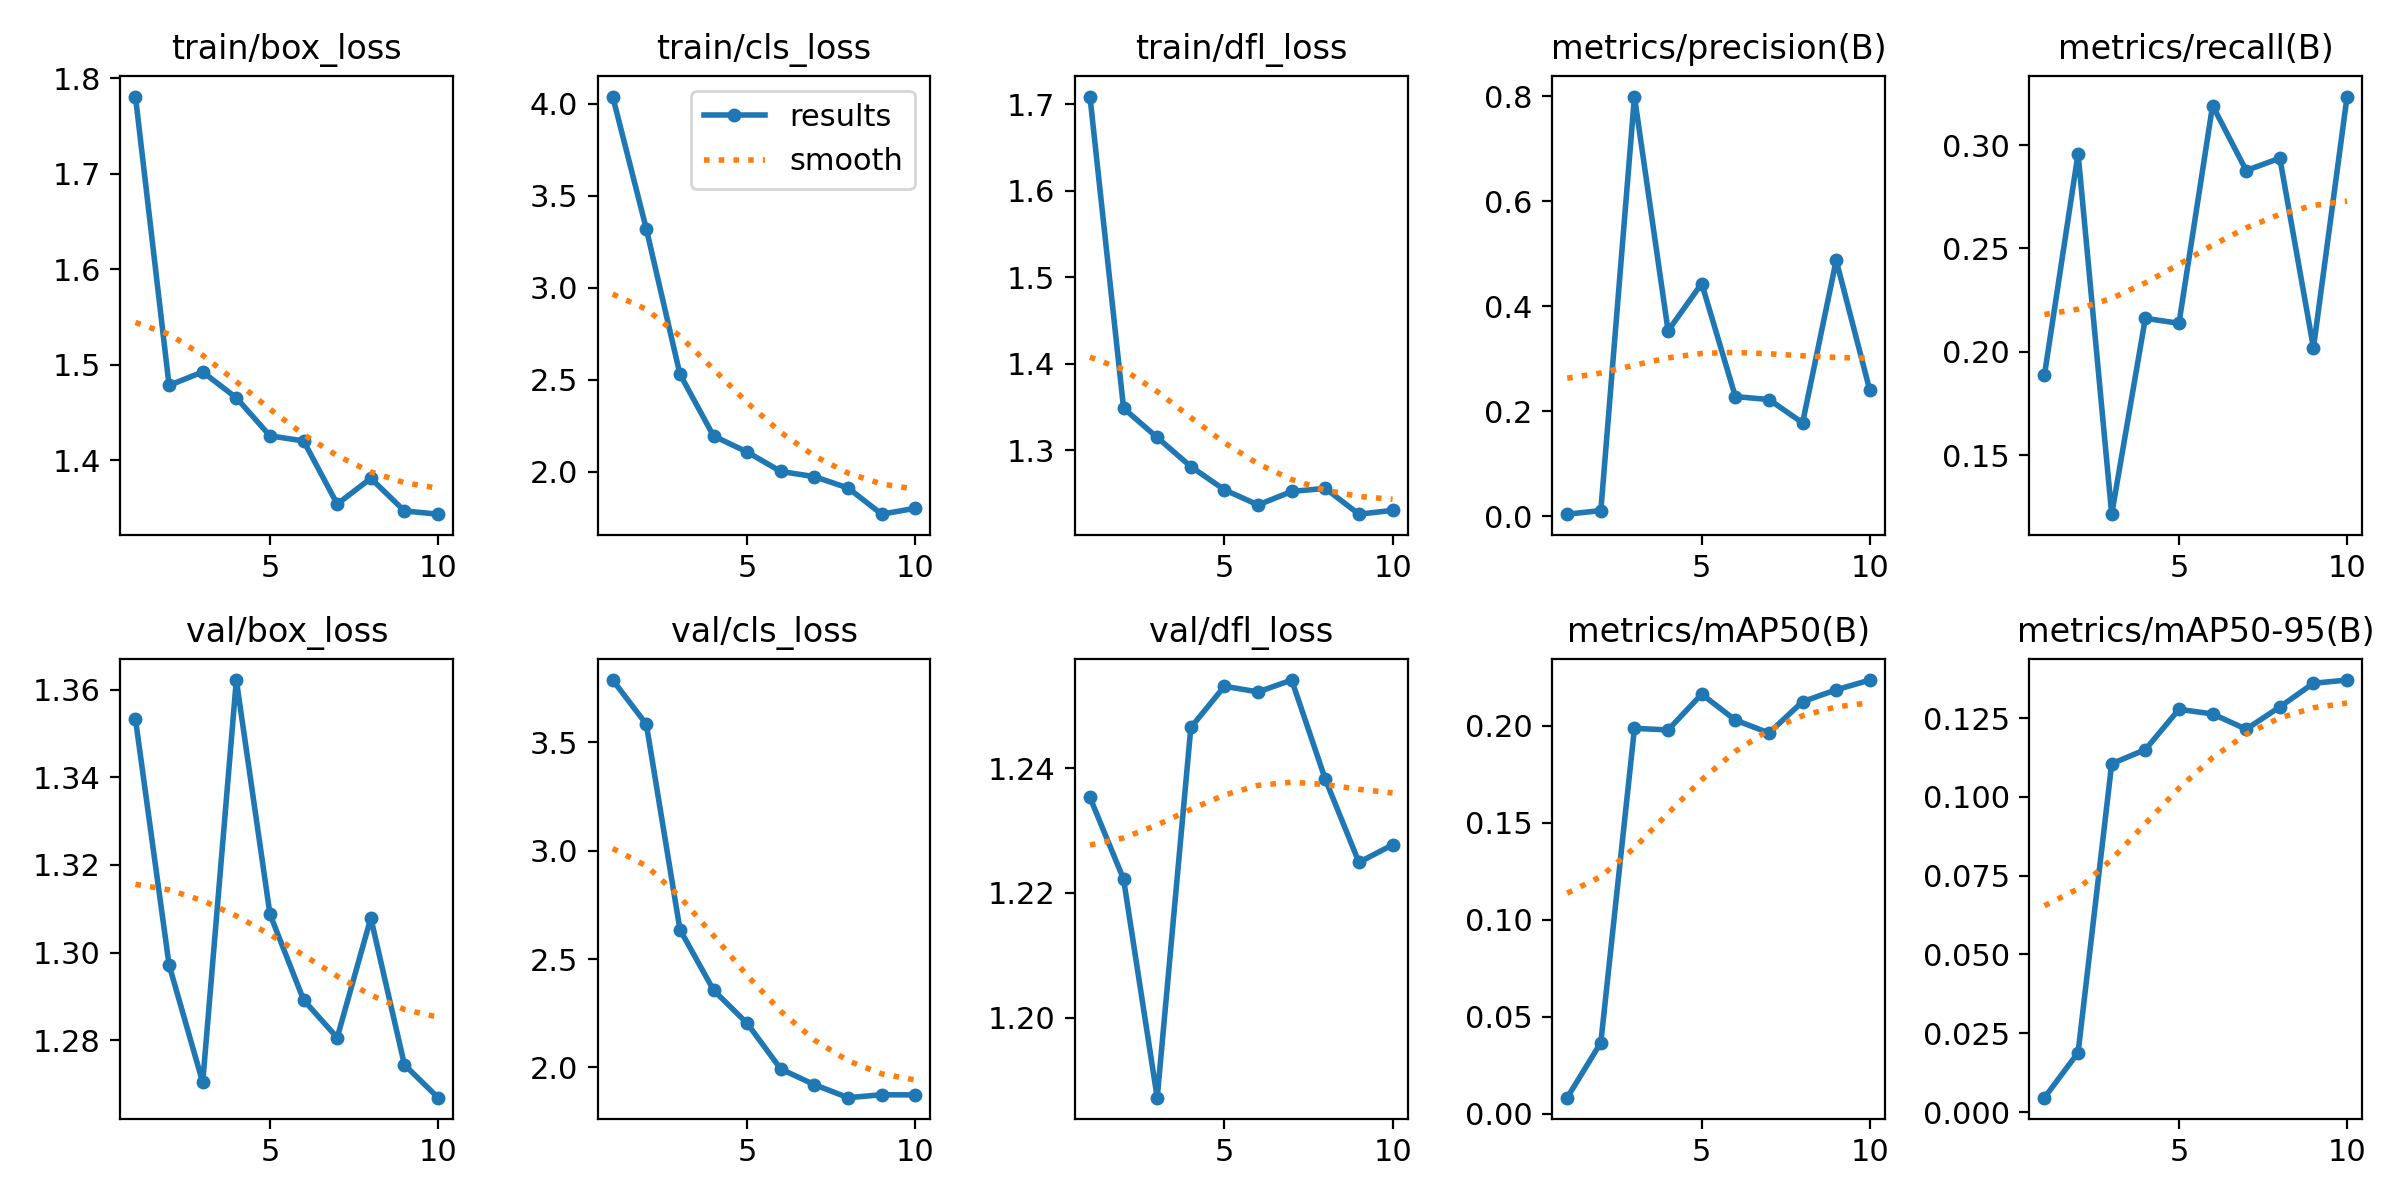

* The second training consisted of images which are zoomed by factor of 8 and images are augmented, RGB channels of the images. We saw some improve in the models performance.



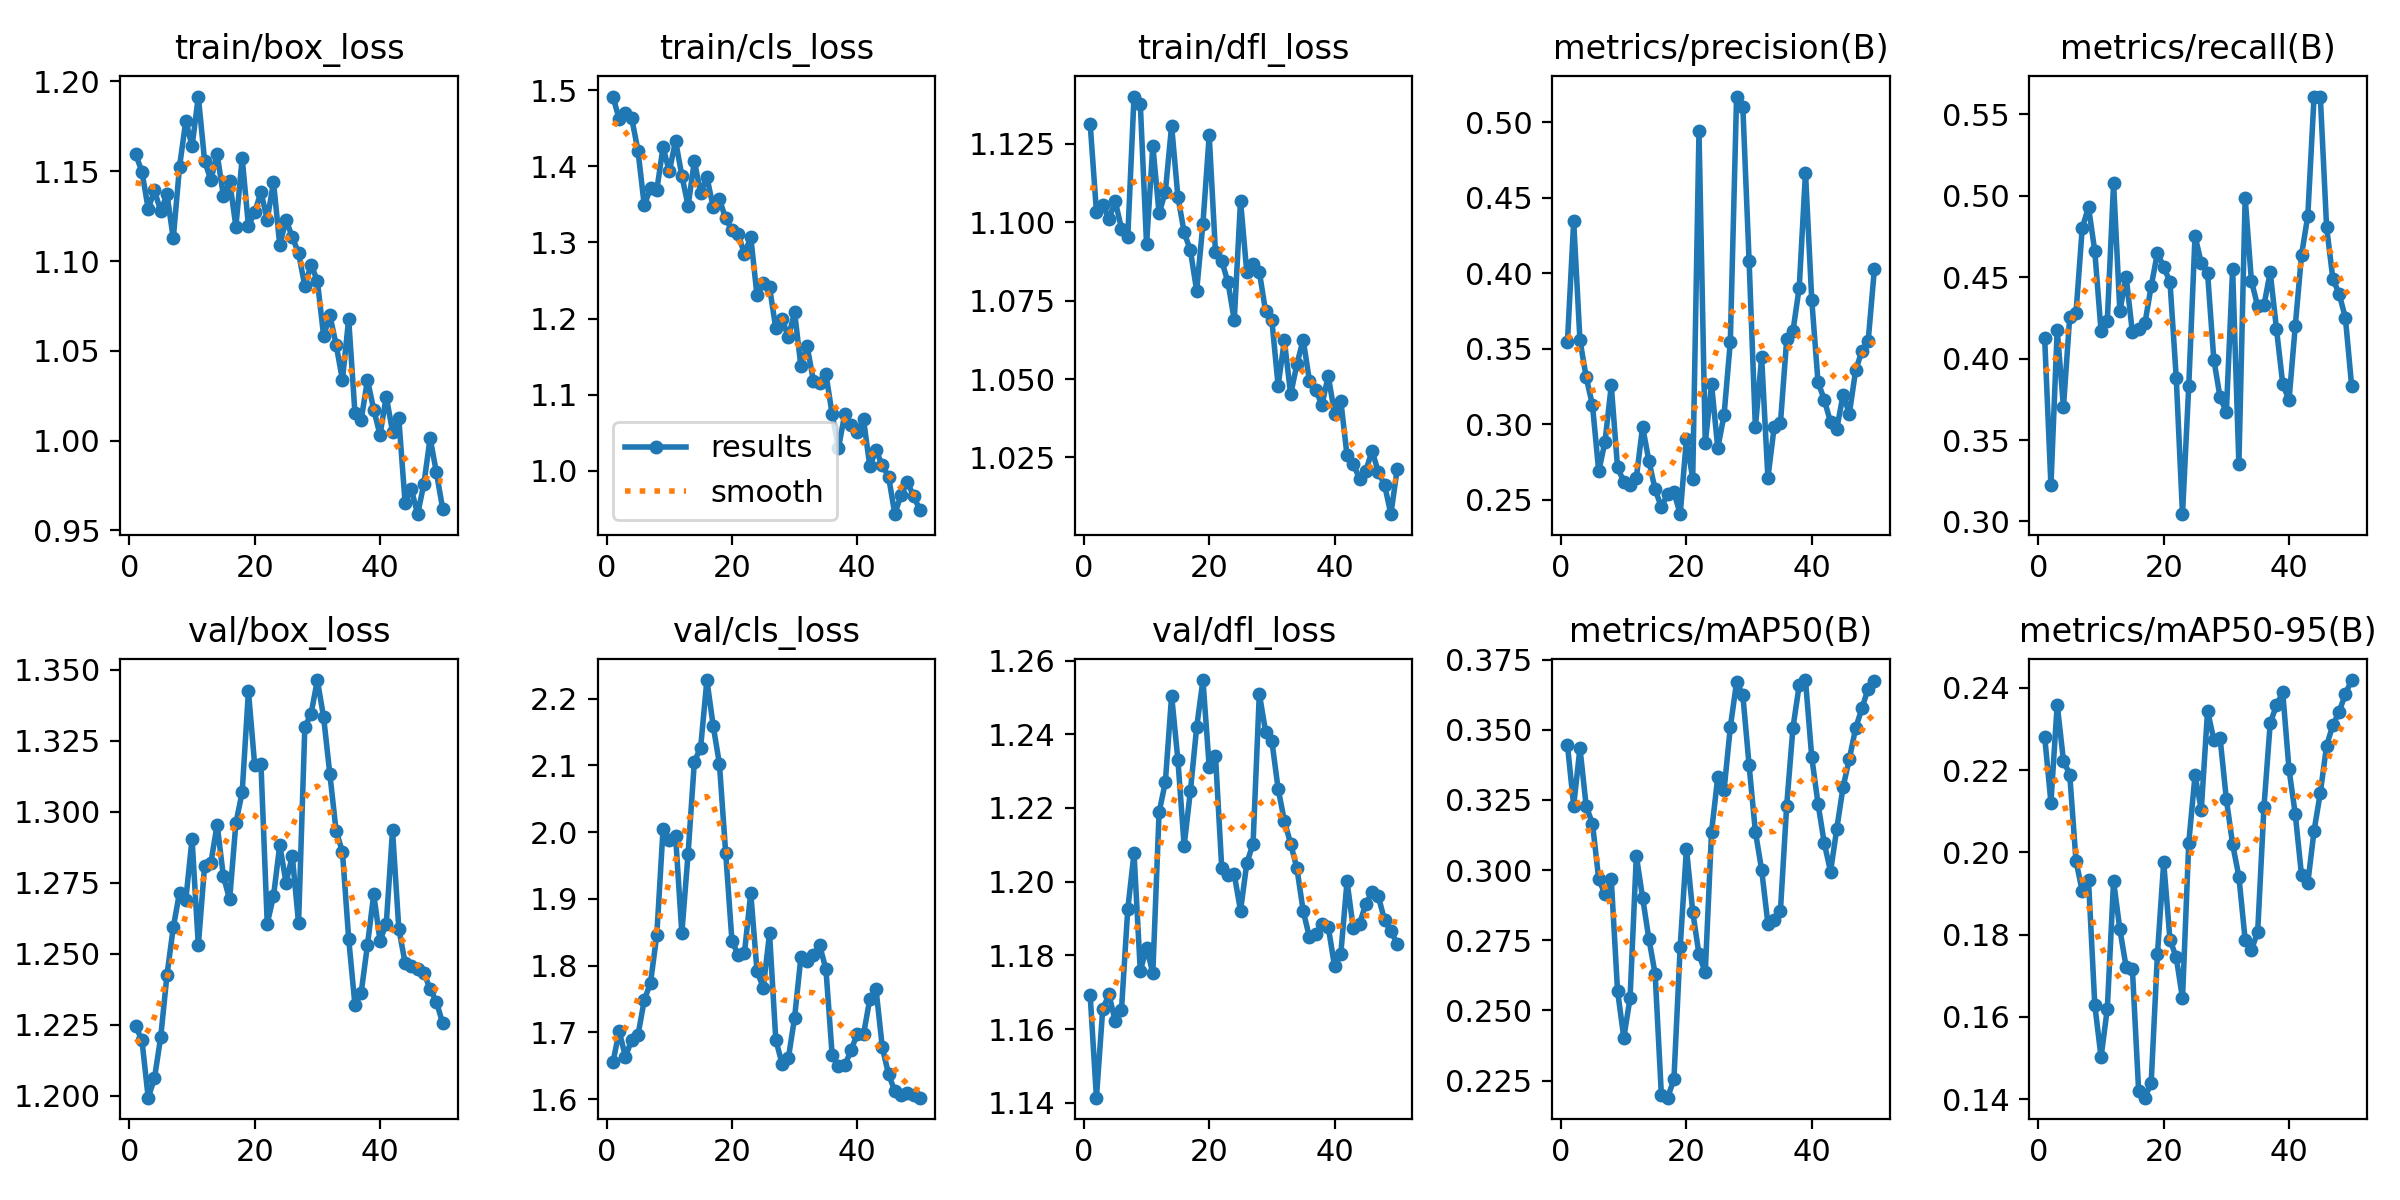

* We can see that with better augmentation and preprocessing, the model performances improves.

## Applications.
The coastal resilience model developed here can help is detecting the range of damages done by natural calamaties. These models can have various applications.


1.   **Real-Time damage detection** -
    The models can be deployed for detecting the damage done be storms, hurricanes and floods. This will help in allocating relief teams,fire bridage and help in crisis managements. Aids and rescue operations can prioritize to areas with maximum damage.

2.  **Urban Planning** -
    With the help of models we can classify locations as special zones where we add regulatory constraints on urban developments. Especially we restrict commercial development in that area which will minimize the damages.
    Houses,buildings and commercial centres should be planned with enough spaces in such zones as they are always prone to higher risk of being damage.


3.  **Insurance Claims** -
    Insurance companies can also implement this models for detecting the severity of damage due to storm. This will help them in assisting their further due diligence more effectively and optimize their business cost.

4.  **Ecosystem Planning** -
    It is clearly seen that the damages are less severe in areas with more trees and zones where the ecosystems are less manipulated. Therefore it becomes necessary that development goes hand in hand with ecological balance. Innovating and incorporating such planning methods will ensure that damage in future can be minimized.